In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torch.nn import init

from torchvision.models.resnet import BasicBlock, ResNet
from torchvision.transforms import ToTensor
import io
from torchvision import models, transforms
import torch.utils.data as data_utils
from PIL import Image
import os

import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F
def default_loader(path):
    return Image.open(path)   

In [2]:
from torchvision.models.resnet import BasicBlock, ResNet
from torch.nn import init

# custom convolutional layer that accounts for transposed image planes as well as conventional 2D conv layers
def conv(in_planes, out_planes, kernel_size=3, stride=1, dilation=1, bias=False, transposed=False):
    if transposed:
        layer = nn.ConvTranspose2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=1, output_padding=1,
                                   dilation=dilation, bias=bias)
    else:
        padding = (kernel_size + 2 * (dilation - 1)) // 2
        layer = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias)
    if bias:
        init.constant(layer.bias, 0)
    return layer

# Returns 2D batch normalisation layer
# the range of activation values for each layer is "forced" to a normalized distribution of a static mean and cov value, mu & beta
# When the activations of a previous layer are forced to a normalized distribution, it makes training of subsequent layers much more efficient
def bn(planes):
    layer = nn.BatchNorm2d(planes)
    # Use mean 0, standard deviation 1 init
    init.constant(layer.weight, 1)
    init.constant(layer.bias, 0)
    return layer


# feature extraction using pretrained residual network - this performs as the decoder component of the architecture
# Resnet addresses the vanishing gradient problem for very deep networks, using skip connections between layers
class FeatureResNet(ResNet):
    def __init__(self):
        super().__init__(BasicBlock, [3, 14, 16, 3], 1000)
        self.conv_f = conv(2,64, kernel_size=3,stride = 1)
        self.ReLu_1 = nn.ReLU(inplace=True)
        self.conv_pre = conv(512, 1024, stride=2, transposed=False)
        self.bn_pre = bn(1024)

    def forward(self, x):
        x1 = self.conv_f(x) #upsample 8 to 64. changed from Ru's original model bc my image set has 8 feature channels for some reason?
        x = self.bn1(x1)
        x = self.relu(x)
        x2 = self.maxpool(x) #maxpool with kernel size of 3 and add padding of 1
        x = self.layer1(x2) #identity sample 64 to 64
        x3 = self.layer2(x) #upsample 64 to 128
        x4 = self.layer3(x3) #upsample 128 to 256
        x5 = self.layer4(x4) #upsample 256 to 512
        x6 = self.ReLu_1(self.bn_pre(self.conv_pre(x5))) #upsample 512 to 1024
        return x1, x2, x3, x4, x5,x6


class SegResNet(nn.Module):
    def __init__(self, num_classes, pretrained_net):
        super().__init__()
        self.pretrained_net = pretrained_net
        self.relu = nn.ReLU(inplace=True)
        self.conv3_2 = conv(1024, 512, stride=1, transposed=False)
        self.bn3_2 = bn(512)
        self.conv4 = conv(512,512, stride=2, transposed=True)
        self.bn4 = bn(512)
        self.conv5 = conv(512, 256, stride=2, transposed=True)
        self.bn5 = bn(256)
        self.conv6 = conv(256, 128, stride=2, transposed=True)
        self.bn6 = bn(128)
        self.conv7 = conv(128, 64, stride=2, transposed=True)
        self.bn7 = bn(64)
        self.conv8 = conv(64, 64, stride=2, transposed=True)
        self.bn8 = bn(64)
        self.conv9 = conv(64, 32, stride=2, transposed=True)
        self.bn9 = bn(32)
        self.convadd = conv(32, 16, stride=1, transposed=False)
        self.bnadd = bn(16)
        self.conv10 = conv(16, num_classes,stride=2, kernel_size=5)
        init.constant(self.conv10.weight, 0)  # Zero init

    def forward(self, x):
        
        '''
        At init, the FeatureResNet() method (aka "decoder") is used to extract features \
        from the input space and then those layer activation values are passed into the \
        encoder's conv layers to reduce dimensionality. Then this is done recursively \
        via gradient descent.
        '''
        x1, x2, x3, x4, x5, x6 = self.pretrained_net(x) #at init, this is used as feature extraction. Then, it's subsequently used as a decoder
        
        x = self.relu(self.bn3_2(self.conv3_2(x6)))
        
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn5(self.conv5(x)))
        #print(x.size())
        x = self.relu(self.bn6(self.conv6(x+x4 )))
        #print(x.size())
        x = self.relu(self.bn7(self.conv7(x+x3 )))
        #print(x.size())
        x = self.relu(self.bn8(self.conv8(x+x2 )))
        #print(x.size())
        x = self.relu(self.bn9(self.conv9(x+x1 )))
        #print(x.size())
        x = self.relu(self.bnadd(self.convadd(x)))
        x = self.conv10(x)
        return x


In [3]:
root_result = 'experiment_numairData/'
model_result = root_result+'model/'
log_result = root_result+'log/'


In [4]:
fnet = FeatureResNet()
fcn = SegResNet(2,fnet)
fcn = fcn.cuda()

model_path = '/home/numairahmed/forked_deepDIC/Deep-Dic-deep-learning-based-digital-image-correlation/experiment_numairData/model/param_all_2_149_374'
# print(torch.cuda.memory_summary(device=None, abbreviated=False))   

# fcn.load_state_dict(torch.load(model_result + 'pretrained_displacementnet'))
fcn.load_state_dict(torch.load(model_path))

fcn.eval()

<ipython-input-2-09500fd8f94c>:22: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(layer.weight, 1)
<ipython-input-2-09500fd8f94c>:23: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(layer.bias, 0)
<ipython-input-2-09500fd8f94c>:72: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(self.conv10.weight, 0)  # Zero init


SegResNet(
  (pretrained_net): FeatureResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [5]:
# fcn.eval()
# print(torch.cuda.memory_summary(device=None, abbreviated=False))   


In [6]:
from scipy.io import savemat
#define region of interest
x1, x2, y1, y2 = 128, 128,1,1     #ylo,yhi,xlo,xhi
x100, x200, y100, y200 = 128, 128,1,1     #ylo,yhi,xlo,xhi
dx1,dx2,dy1,dy2 = 0,0,0,0

h0 = x2-x1
w0 = y2-y1

disp_1_x = np.zeros((128,128))
disp_1_y = np.zeros((128,128))

i=0
path_img = ''
results_path = '/home/numairahmed/Deep-Dic-deep-learning-based-digital-image-correlation/predict_results'
img_num = 2 #number of test samples available

# for i in range(1,img_num):
h0 = x2-x1
w0 = y2-y1
hnew = int((h0//32+1)*32)
wnew = int((w0//32+1)*32)
newsize = (wnew,hnew)

dir_name = '/home/numairahmed/deepDIC/images/image_sample_pairs/experiment_samples/tensile_test_images/cropped'
img_pair = 'train_image_' #pick randomly from test images dir
img_input = os.path.join(dir_name, img_pair)

img1 = default_loader(f'{img_input}1.png') #undeformed img
# img1_c = img1.crop((y1,x1,y2,x2))
# img1_r = img1_c.resize(newsize)
img2 = default_loader(f'{img_input}82.png') #deformed img
# img2_c = img2.crop((y1,x1,y2,x2))
# img2_r = img2_c.resize(newsize)

# img_1 = ToTensor()(img1_r)
# img_2 = ToTensor()(img2_r)
img_1 = ToTensor()(img1)
img_1 = img_1[::4,:,:]
img_2 = ToTensor()(img2)
img_2 = img_2[::4,:,:]
print(f"img_1{img_1.shape} img_2{img_2.shape} ")

imgs = torch.cat((img_1/np.max(img_1.numpy()), img_2/np.max(img_2.numpy())), 0)
imgs = imgs.unsqueeze(0)
imgs = imgs.type(torch.cuda.FloatTensor)
imgs = Variable(imgs).cuda()
print(f"{imgs.shape} ")

predict = fcn(imgs)
predict_np = predict.detach().cpu().numpy().squeeze(0)

# plt.figure()
# plt.plot(predict_np)
# plt.show()

print(f"predict shape: {predict_np.shape}\n predict shape: {predict.size()}  ")

#update region of interest
dy1 = dy1+np.mean(predict_np[0,:,:])*(w0)/(wnew)/2.0
dy2 = dy2+np.mean(predict_np[0,:,:])*(w0)/(wnew)/2.0
dx1 = dx1+np.mean(predict_np[1,:,:])*(h0)/(hnew)/2.0 
dx2 = dx2+np.mean(predict_np[1,:,:])*(h0)/(hnew)/2.0

print(f"dy1 {dy1}\n dy2 {dy2}\n dx1 {dx1}\n dx2 {dx2}  ")

x10,x20,y10,y20 = x1,x2,y1,y2
h0 = x20-x10
w0 = y20-y10

x1 = np.int(x100-dx1)
y1 = np.int(y100-dy1)
x2 = round(x200-dx2)
y2 = round(y200-dy2)  ###new roi updated
    
disp_1_x = predict_np/2

position = [x1,x2,y1,y2,h0,w0]

matname = results_path+'/result_'+str(i)+'_position1.mat'
mdic = {"position": position, "label": "position"}
savemat(matname,mdic)

matname = results_path+'/result_'+str(i)+'_disp_0_x.mat'
mdic = {"disp_1_x": disp_1_x, "label": "disp_1_x"}
savemat(matname,mdic)
    

img_1torch.Size([1, 256, 256]) img_2torch.Size([1, 256, 256]) 
torch.Size([1, 2, 256, 256]) 
predict shape: (2, 256, 256)
 predict shape: torch.Size([1, 2, 256, 256])  
dy1 0.0
 dy2 0.0
 dx1 0.0
 dx2 0.0  


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<ipython-input-6-0ad9ba49b78b>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1 = np.int(x100-dx1)
<ipython-input-6-0ad9ba49b78b>:72: Deprecatio

In [7]:
# ## load groundtruth disp field data

# import glob
# import os
# import scipy.io as sio

# dir_groundtruths = '/home/numairahmed/deepDIC/images/image_sample_pairs/experiment_samples/gts_severe' # use your path
# filename = os.path.join(dir_groundtruths, img_pair)

# gt = sio.loadmat(f'{filename}severe.mat')['Disp_field_1'].astype(float)
# gt = np.asarray(gt)
# # gt = np.moveaxis(gt, -1, 0)
        
# print(disp_1_x.shape)

predict shape: (256, 256)


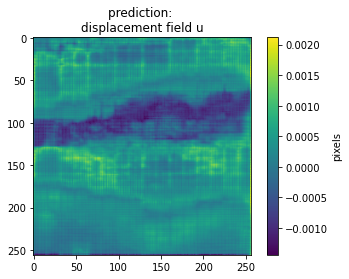

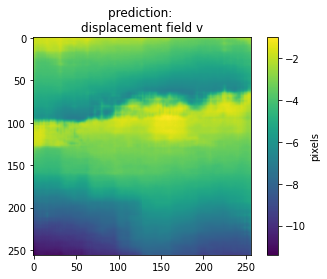

In [8]:
print(f"predict shape: {predict_np[0].shape}")
# [25:225,25:225]
plt.figure()
plt.imshow(disp_1_x[0])
plt.colorbar(label='pixels')
plt.title('prediction: \ndisplacement field u')
# plt.figure()
# plt.imshow(gt[0])
# plt.colorbar(label='pixels')
# plt.title('gt: displacement field u')

plt.figure()
plt.imshow(disp_1_x[1])
plt.colorbar(label='pixels')
plt.title('prediction: \ndisplacement field v')
# plt.figure()
# plt.imshow(gt[1])
# plt.colorbar(label='pixels')
# plt.title('gt: displacement field v')

plt.show()

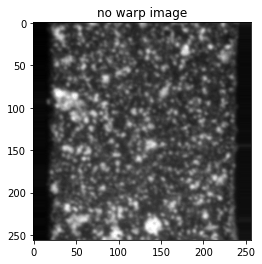

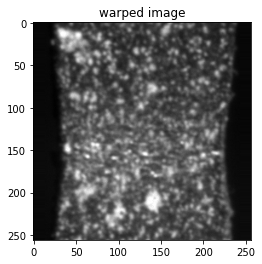

In [9]:
plt.figure()
plt.title('no warp image')
plt.imshow(img1)
plt.figure()
plt.title('warped image')
plt.imshow(img2)
plt.show()